## Name: Evan Johnson

Your instructor decides to quit DU and move to Japan to be with his daughter and new grandchild.  Since Japan is like England and the driver sits on the right and traffic flows on the left side of the road, his American cars are useless in Japan.  Therefore, he is going to give his 5 cars (Mazda CX-5, Tesla Model 3, Ford Focus, Tesla Cybertruck, and Jeep Wrangler), to his three favorite INFO 3440 students. You know who you are :) but for these purposes, we will call you Student 1, Student 2, and Student 3.

- Of course there's some rules to this giveaway:

- No student can receive more than three cars

- Each student must receive at least one car

- Your instructor doesn't want to deal with this anymore, so all the cars must be given away

- If a student gets one of the Teslas, (s)he cannot receive the other Tesla

- Student 1 is obviously his most favorite, so in this case Student 2 may not receive more cars than student 1

- Obviously, the same car can not be given to more than 1 student

- To help with gas mileage concerns, If the Jeep Wrangler goes to Student 1, then Student 1 must also get the Ford Focus.

- If Student 1 gets the Ford Focus OR if Student 2 gets the Cybertruck, then the CX-5 must go to Student 3.


As we have also established, your instructor is basically lazy and wants to minimize the number of miles he has to drive to drop these cars off at the students' houses.  Student 1 lives 17 miles away from your instructor, where student 2 lives 12 miles away and student 3 lives 15 miles away

In [ ]:
!pip install pyomo
!apt-get install -y -qq glpk-utils
import pandas as pd
import pyomo.environ as pe
import matplotlib.pyplot as plt
import seaborn as sns

import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cars = ['Mazda CX-5', 'Tesla Model 3', 'Ford Focus', 'Tesla Cybertruck', 'Jeep Wrangler']
data = [1,1,1,1,1]
cars_df = pd.DataFrame(data, columns = ['Amount'], index = cars)
cars_df

,Amount
Mazda CX-5,1
Tesla Model 3,1
Ford Focus,1
Tesla Cybertruck,1
Jeep Wrangler,1


In [ ]:
miles = {'Student 1':17, 'Student 2': 12, 'Student 3': 15}
miles_df = pd.DataFrame(miles, index = ['Distance'])
miles_df

,Student 1,Student 2,Student 3
Distance,17,12,15


In [ ]:
model = pe.ConcreteModel()
model.student1 = pe.Var(cars, domain = pe.Binary)
model.student2 = pe.Var(cars, domain = pe.Binary)
model.student3 = pe.Var(cars, domain = pe.Binary)
model.pprint()

3 Var Declarations
    student1 : Size=5, Index={Mazda CX-5, Tesla Model 3, Ford Focus, Tesla Cybertruck, Jeep Wrangler}
        Key              : Lower : Value : Upper : Fixed : Stale : Domain
              Ford Focus :     0 :  None :     1 : False :  True : Binary
           Jeep Wrangler :     0 :  None :     1 : False :  True : Binary
              Mazda CX-5 :     0 :  None :     1 : False :  True : Binary
        Tesla Cybertruck :     0 :  None :     1 : False :  True : Binary
           Tesla Model 3 :     0 :  None :     1 : False :  True : Binary
    student2 : Size=5, Index={Mazda CX-5, Tesla Model 3, Ford Focus, Tesla Cybertruck, Jeep Wrangler}
        Key              : Lower : Value : Upper : Fixed : Stale : Domain
              Ford Focus :     0 :  None :     1 : False :  True : Binary
           Jeep Wrangler :     0 :  None :     1 : False :  True : Binary
              Mazda CX-5 :     0 :  None :     1 : False :  True : Binary
        Tesla Cybertruck :     0 :  N

In [ ]:
model.obj = pe.Objective(expr = sum(miles_df.loc['Distance', 'Student 1'] * cars_df.loc[index, 'Amount'] * model.student1[index] * 2 for index in cars) +
                         sum(miles_df.loc['Distance', 'Student 2'] * cars_df.loc[index, 'Amount'] * model.student2[index] * 2 for index in cars) +
                         sum(miles_df.loc['Distance', 'Student 3'] * cars_df.loc[index, 'Amount'] * model.student3[index] * 2 for index in cars),
                         sense = pe.minimize)

In [ ]:
model.obj.pprint()

obj : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 34*student1[Mazda CX-5] + 34*student1[Tesla Model 3] + 34*student1[Ford Focus] + 34*student1[Tesla Cybertruck] + 34*student1[Jeep Wrangler] + 24*student2[Mazda CX-5] + 24*student2[Tesla Model 3] + 24*student2[Ford Focus] + 24*student2[Tesla Cybertruck] + 24*student2[Jeep Wrangler] + 30*student3[Mazda CX-5] + 30*student3[Tesla Model 3] + 30*student3[Ford Focus] + 30*student3[Tesla Cybertruck] + 30*student3[Jeep Wrangler]


In [ ]:
# Max and min cars per student
model.maxcars_student1 = pe.Constraint(expr = (1, sum(model.student1[index] for index in cars),3))
model.maxcars_student2 = pe.Constraint(expr = (1, sum(model.student2[index] for index in cars),3))
model.maxcars_student3 = pe.Constraint(expr = (1, sum(model.student3[index] for index in cars),3))

# Get rid of all cars
model.allcars = pe.Constraint(expr = sum(model.student1[index] for index in cars) +
                              sum(model.student2[index] for index in cars) +
                              sum(model.student3[index] for index in cars) == 5)

# Max teslas
model.maxtesla_student1 = pe.Constraint(expr = model.student1['Tesla Model 3'] + model.student1['Tesla Cybertruck'] <= 1)
model.maxtesla_student2 = pe.Constraint(expr = model.student2['Tesla Model 3'] + model.student2['Tesla Cybertruck'] <= 1)
model.maxtesla_student3 = pe.Constraint(expr = model.student3['Tesla Model 3'] + model.student3['Tesla Cybertruck'] <= 1)

# Student 2 can't get more than student 1
model.favoritestudent = pe.Constraint(expr = sum(model.student1[index] for index in cars) >= sum(model.student2[index] for index in cars))

# Students can't have the same car
model.noduplicateCX5 = pe.Constraint(expr = (model.student1['Mazda CX-5'] + model.student2['Mazda CX-5'] + model.student3['Mazda CX-5'] <= 1))
model.noduplicateModel3 = pe.Constraint(expr = (model.student1['Tesla Model 3'] + model.student2['Tesla Model 3'] + model.student3['Tesla Model 3'] <= 1))
model.noduplicateFord = pe.Constraint(expr = (model.student1['Ford Focus'] + model.student2['Ford Focus'] + model.student3['Ford Focus'] <= 1))
model.noduplicateCybertruck = pe.Constraint(expr = (model.student1['Tesla Cybertruck'] + model.student2['Tesla Cybertruck'] + model.student3['Tesla Cybertruck'] <= 1))
model.noduplicateJeep = pe.Constraint(expr = (model.student1['Jeep Wrangler'] + model.student2['Jeep Wrangler'] + model.student3['Jeep Wrangler'] <= 1))



# If the Jeep Wrangler goes to Student 1, then Student 1 must also get the Ford Focus
model.jeep_ford = pe.Constraint(expr = model.student1['Jeep Wrangler'] - model.student1['Ford Focus'] <= 0)

# If Student 1 gets the Ford Focus OR if Student 2 gets the Cybertruck, then the CX-5 must go to Student 3
model.cx5 = pe.Constraint(expr = model.student1['Ford Focus'] + model.student2['Tesla Cybertruck'] <= 2 * model.student3['Mazda CX-5'])

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


In [ ]:
opt = pe.SolverFactory('glpk')
success = opt.solve(model, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp1vceurin.glpk.raw --wglp /tmp/tmpdo03uwsa.glpk.glp --cpxlp
 /tmp/tmpqpr5w4l4.pyomo.lp
Reading problem data from '/tmp/tmpqpr5w4l4.pyomo.lp'...
/tmp/tmpqpr5w4l4.pyomo.lp:175: warning: lower bound of variable 'x2' redefined
/tmp/tmpqpr5w4l4.pyomo.lp:175: warning: upper bound of variable 'x2' redefined
18 rows, 15 columns, 81 non-zeros
15 integer variables, all of which are binary
190 lines were read
Writing problem data to '/tmp/tmpdo03uwsa.glpk.glp'...
150 lines were written
GLPK Integer Optimizer 5.0
18 rows, 15 columns, 81 non-zeros
15 integer variables, all of which are binary
Preprocessing...
18 rows, 15 columns, 81 non-zeros
15 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  2.000e+00  ratio =  2.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 18
Solving LP relaxation...
GLPK Simplex Optimizer 5

In [ ]:
obj_val = model.obj.expr()
print(f'Minimum Miles Traveled = {obj_val}')

Minimum Miles Traveled = 146.0


In [ ]:
for DV in model.component_objects(pe.Var):
    print(DV)
    for var in DV:
        print(" ", var, DV[var].value)

student1
  Mazda CX-5 1.0
  Tesla Model 3 0.0
  Ford Focus 0.0
  Tesla Cybertruck 1.0
  Jeep Wrangler 0.0
student2
  Mazda CX-5 0.0
  Tesla Model 3 1.0
  Ford Focus 1.0
  Tesla Cybertruck 0.0
  Jeep Wrangler 0.0
student3
  Mazda CX-5 0.0
  Tesla Model 3 0.0
  Ford Focus 0.0
  Tesla Cybertruck 0.0
  Jeep Wrangler 1.0


In [ ]:
DV_solution = pd.DataFrame()
for index in cars:
    DV_solution.loc['Student 1', index] = model.student1[index].value
    DV_solution.loc['Student 2', index] = model.student2[index].value
    DV_solution.loc['Student 3', index] = model.student3[index].value
print(f'Minimum Miles Traveled = {obj_val}')
DV_solution

Minimum Miles Traveled = 146.0


,Mazda CX-5,Tesla Model 3,Ford Focus,Tesla Cybertruck,Jeep Wrangler
Student 1,1.0,0.0,0.0,1.0,0.0
Student 2,0.0,1.0,1.0,0.0,0.0
Student 3,0.0,0.0,0.0,0.0,1.0


([], [])

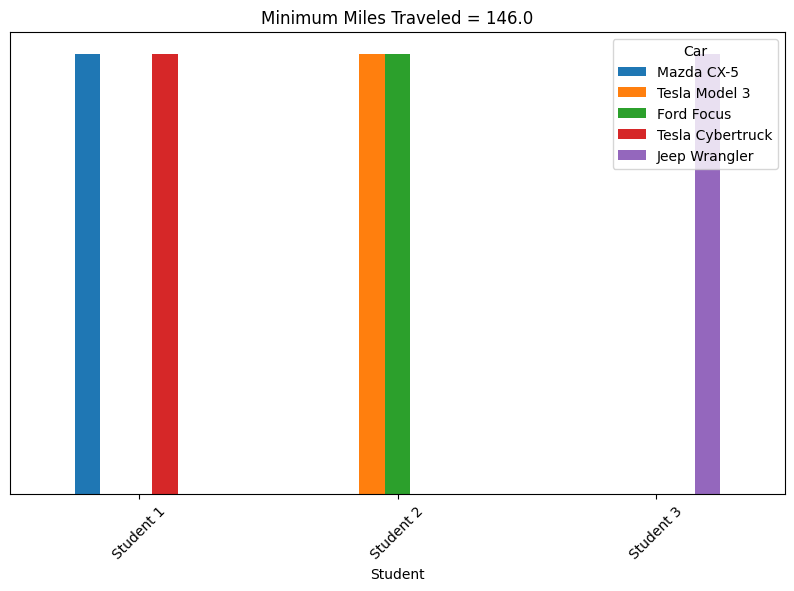

In [ ]:
DV_solution.plot(kind='bar', figsize=(10, 6))
plt.title(f'Minimum Miles Traveled = {obj_val}')
plt.xlabel('Student')
plt.xticks(rotation=45)
plt.legend(title='Car')
plt.grid(axis='y', linestyle='--')
plt.yticks([])